In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math

In [2]:
pd.to_datetime(202)

Timestamp('1970-01-01 00:00:00.000000202')

In [3]:
##절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
from library.quant_functions import anal_funcs, data_funcs

In [4]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [5]:
import yfinance as yf
## FRED 정보 수집
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

## Funcs

In [257]:
def addBollinger(df, period=120, col='Close'):
    """
    Add the simple moving average column to dataframe 

    Parameters
    ----------
    df : pandas dataframe
    period : int
        Period of each calculation

    Returns
    -------
    df : pandas dataframe
        BollingerBand
    """
    bbmid_series = df[col].rolling(window=period).mean()
    series_stdev = df[col].rolling(window=period).std()
    df['UpperBand_S1'] = bbmid_series + 1*series_stdev
    df['UpperBand_S2'] = bbmid_series + 2*series_stdev
    df['UpperBand_S3'] = bbmid_series + 3*series_stdev
    df['LowerBand_S1'] = bbmid_series - 1*series_stdev
    df['LowerBand_S2'] = bbmid_series - 2*series_stdev
    df['LowerBand_S3'] = bbmid_series - 3*series_stdev
    df['MiddleBand'] = bbmid_series
    df['Bandwidth'] = df['UpperBand_S3'] - df['LowerBand_S3']  
    
    return df

def plot_BBband(df, col, log_scale=False):
    """
    plot Bollinger graph

    Parameters
    ----------
    df : pandas dataframe
        BollingerBand
    period : int
        Period of each calculation

    Returns
    -------
    None
    """
    #Bollinger Bands
    fig, ax = plt.subplots(figsize=(14,7))
    ax.plot(df.index, df['UpperBand_S1'], c='#FB8DA0', label='Upper STD1', lw=1, ls='--')
    ax.plot(df.index, df['UpperBand_S2'], c='#FB6B90', label='Upper STD2', lw=1, ls='--')
    ax.plot(df.index, df['UpperBand_S3'], c='#FB4570', label='Upper STD3', lw=2)
    ax.plot(df.index, df['LowerBand_S1'], c='#0E86D4', label='Lower STD1', lw=1, ls='--')
    ax.plot(df.index, df['LowerBand_S2'], c='#055C9D', label='Lower STD2', lw=1, ls='--')
    ax.plot(df.index, df['LowerBand_S3'], c='#003060', label='Lower STD3', lw=2)
    ax.plot(df.index, df['MiddleBand'], c='black', label='Middle Band', lw=1)
    ax.plot(df.index, df[col], c='#FAD02C', label='Market', lw=2)
    plt.legend()
    plt.yscale('log') if log_scale == True else None
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.linspace(xmin, xmax, 6))
    plt.show()

## Proc

In [249]:
df = data_funcs.get_merged_df('^IXIC', '^GSPC', 'TQQQ', 'PSQ', 'TMF')

[*********************100%***********************]  5 of 5 completed


In [258]:
ticker = '^IXIC'
data = addBollinger(df[[ticker]], 20, ticker).dropna()

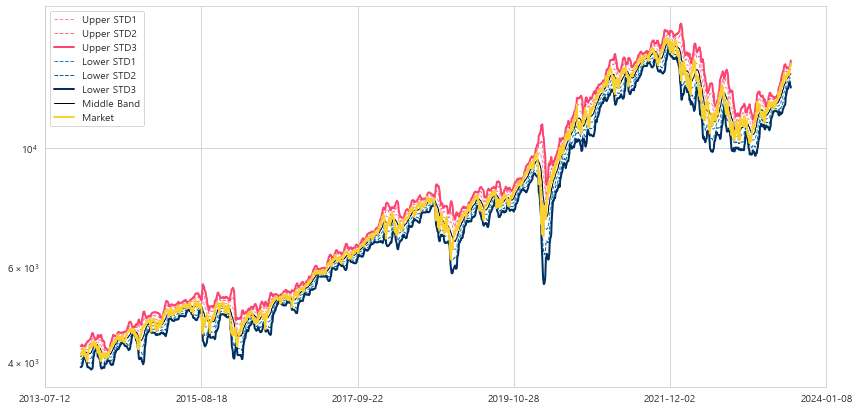

In [259]:
plot_BBband(data.tail(20*12*10), ticker, log_scale=True)

## Simulation

In [367]:
data = addBollinger(df[[ticker]], 20, ticker).dropna()
## data = data.tail(20*12*30)

In [376]:
temp = df[['TQQQ', 'TMF']][data.index[0]:].pct_change().dropna().copy()

simulation = data[[ticker]].pct_change().fillna(0)
simulation['strategy'] = simulation[ticker].copy()
# Create signal
simulation['signal'] = 0
## simulation['signal'][(data[ticker] <= data['UpperBand_S3'])&(data[ticker] >= data['LowerBand_S1'])] = 1
simulation['signal'][(data[ticker] >= data['LowerBand_S3'])] = 1
# Create change
simulation['change'] = simulation['signal'].diff().fillna(0)
# Create position 
simulation['position'] = -1
simulation['position'][(simulation['signal']==1).shift(1).fillna(False)] = 3


## simulation['strategy'][simulation['position'] == 0] = temp['TMF'][simulation['position'] == 0]
## simulation['strategy'][simulation['position'] == 0] = 0
## simulation['strategy'][simulation['position'] == 1] = temp['TQQQ'][simulation['position'] == 1] 
## simulation = simulation[temp.index[0]:]

simulation['strategy'] = simulation[ticker]*simulation['position']
simulation[[ticker, 'strategy']] = (simulation[[ticker, 'strategy']] + 1).cumprod()
simulation[[ticker, 'strategy']] = simulation[[ticker, 'strategy']] /np.array(simulation[[ticker, 'strategy']])[0]

<AxesSubplot:xlabel='Date'>

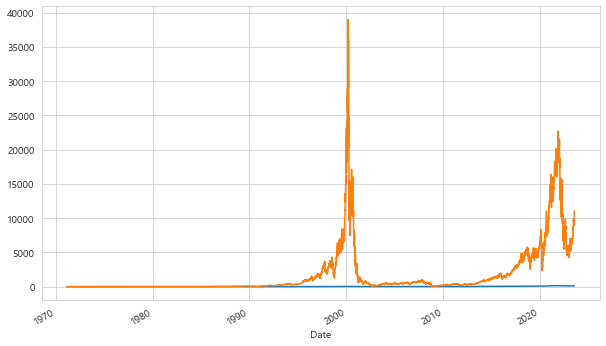

In [377]:
simulation[ticker].plot()
simulation['strategy'].plot()

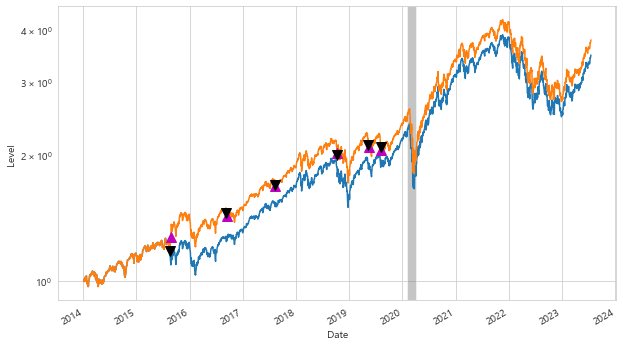

In [305]:
fig = plt.figure(figsize=(10, 6))
# Add a subplot and label for y-axis
ax = fig.add_subplot(111,  ylabel='Level')
simulation[ticker].plot()
simulation['strategy'].plot()
# Plot the buy signals
ax.plot(simulation.loc[simulation['change'] == 1.0].index, 
         simulation['strategy'][simulation['change'] == 1.0],
         '^', markersize=10, color='m')
# Plot the sell signals
ax.plot(simulation.loc[simulation['change'] == -1.0].index, 
         simulation['strategy'][simulation['change'] == -1.0],
         'v', markersize=10, color='k')
plt.yscale('log')


## 경기침체
# plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
# plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
# plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
# plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
# plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
# plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
# plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)

plt.show()